# Predicting the number of pit stops

The number of pit stops and their duration have decreased with the years. In the first phase of this subproject I'll try to predict how many stops will there be in the race and later I would like to predict when yould it happen.

Bur first, some EDA...

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/MovqJSMROh1gA/giphy.gif")

## EDA

In [65]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

import pandas as pd
import numpy as np
import seaborn as sns

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")

We should import info from the results data so that we can know the result of each driver at the end of each race. We should only take into account the drivers that ended each race. If the driver do not ends the race, they will probably have no pit stops.

In [66]:
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
PitsDF=PitsDF.drop(columns=['Unnamed: 0'])

In [67]:
#Creating Season-Round feature:
ResultsDF["Season-Round-Driver"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF["Driver.driverId"].astype(str)
PitsDF["Season-Round-Driver"]=PitsDF["season"].astype(str)+"-"+PitsDF["round"].astype(str)+"-"+PitsDF["driverId"].astype(str)


In [90]:
#Left Join of the Pits DF with the Results DF
PitsExtraDF=PitsDF.merge(ResultsDF[["Season-Round-Driver","status",'Constructor.constructorId','Constructor.name',"laps"]],on="Season-Round-Driver",how="left")

In [95]:
#Creating the feature of laps per pitstop. This tells us how many laps in average you can do between pit stops
PitsExtraDF["LapsbetweenPitstops"]=PitsExtraDF["laps"]/PitsExtraDF["stop"]


In [107]:
#Pits of drivers that ended the races:
PitsExtraDF_Finished=PitsExtraDF[PitsExtraDF["status"]=="Finished"]

### Average number of laps between pit stops per circuit

We can see that contrary to what it was believed, the number of laps on average per pit stop have increased and decreased depending on each circuit. Also, there are circuits that have only been present in one or two seasons, so this line plots should be ignored.

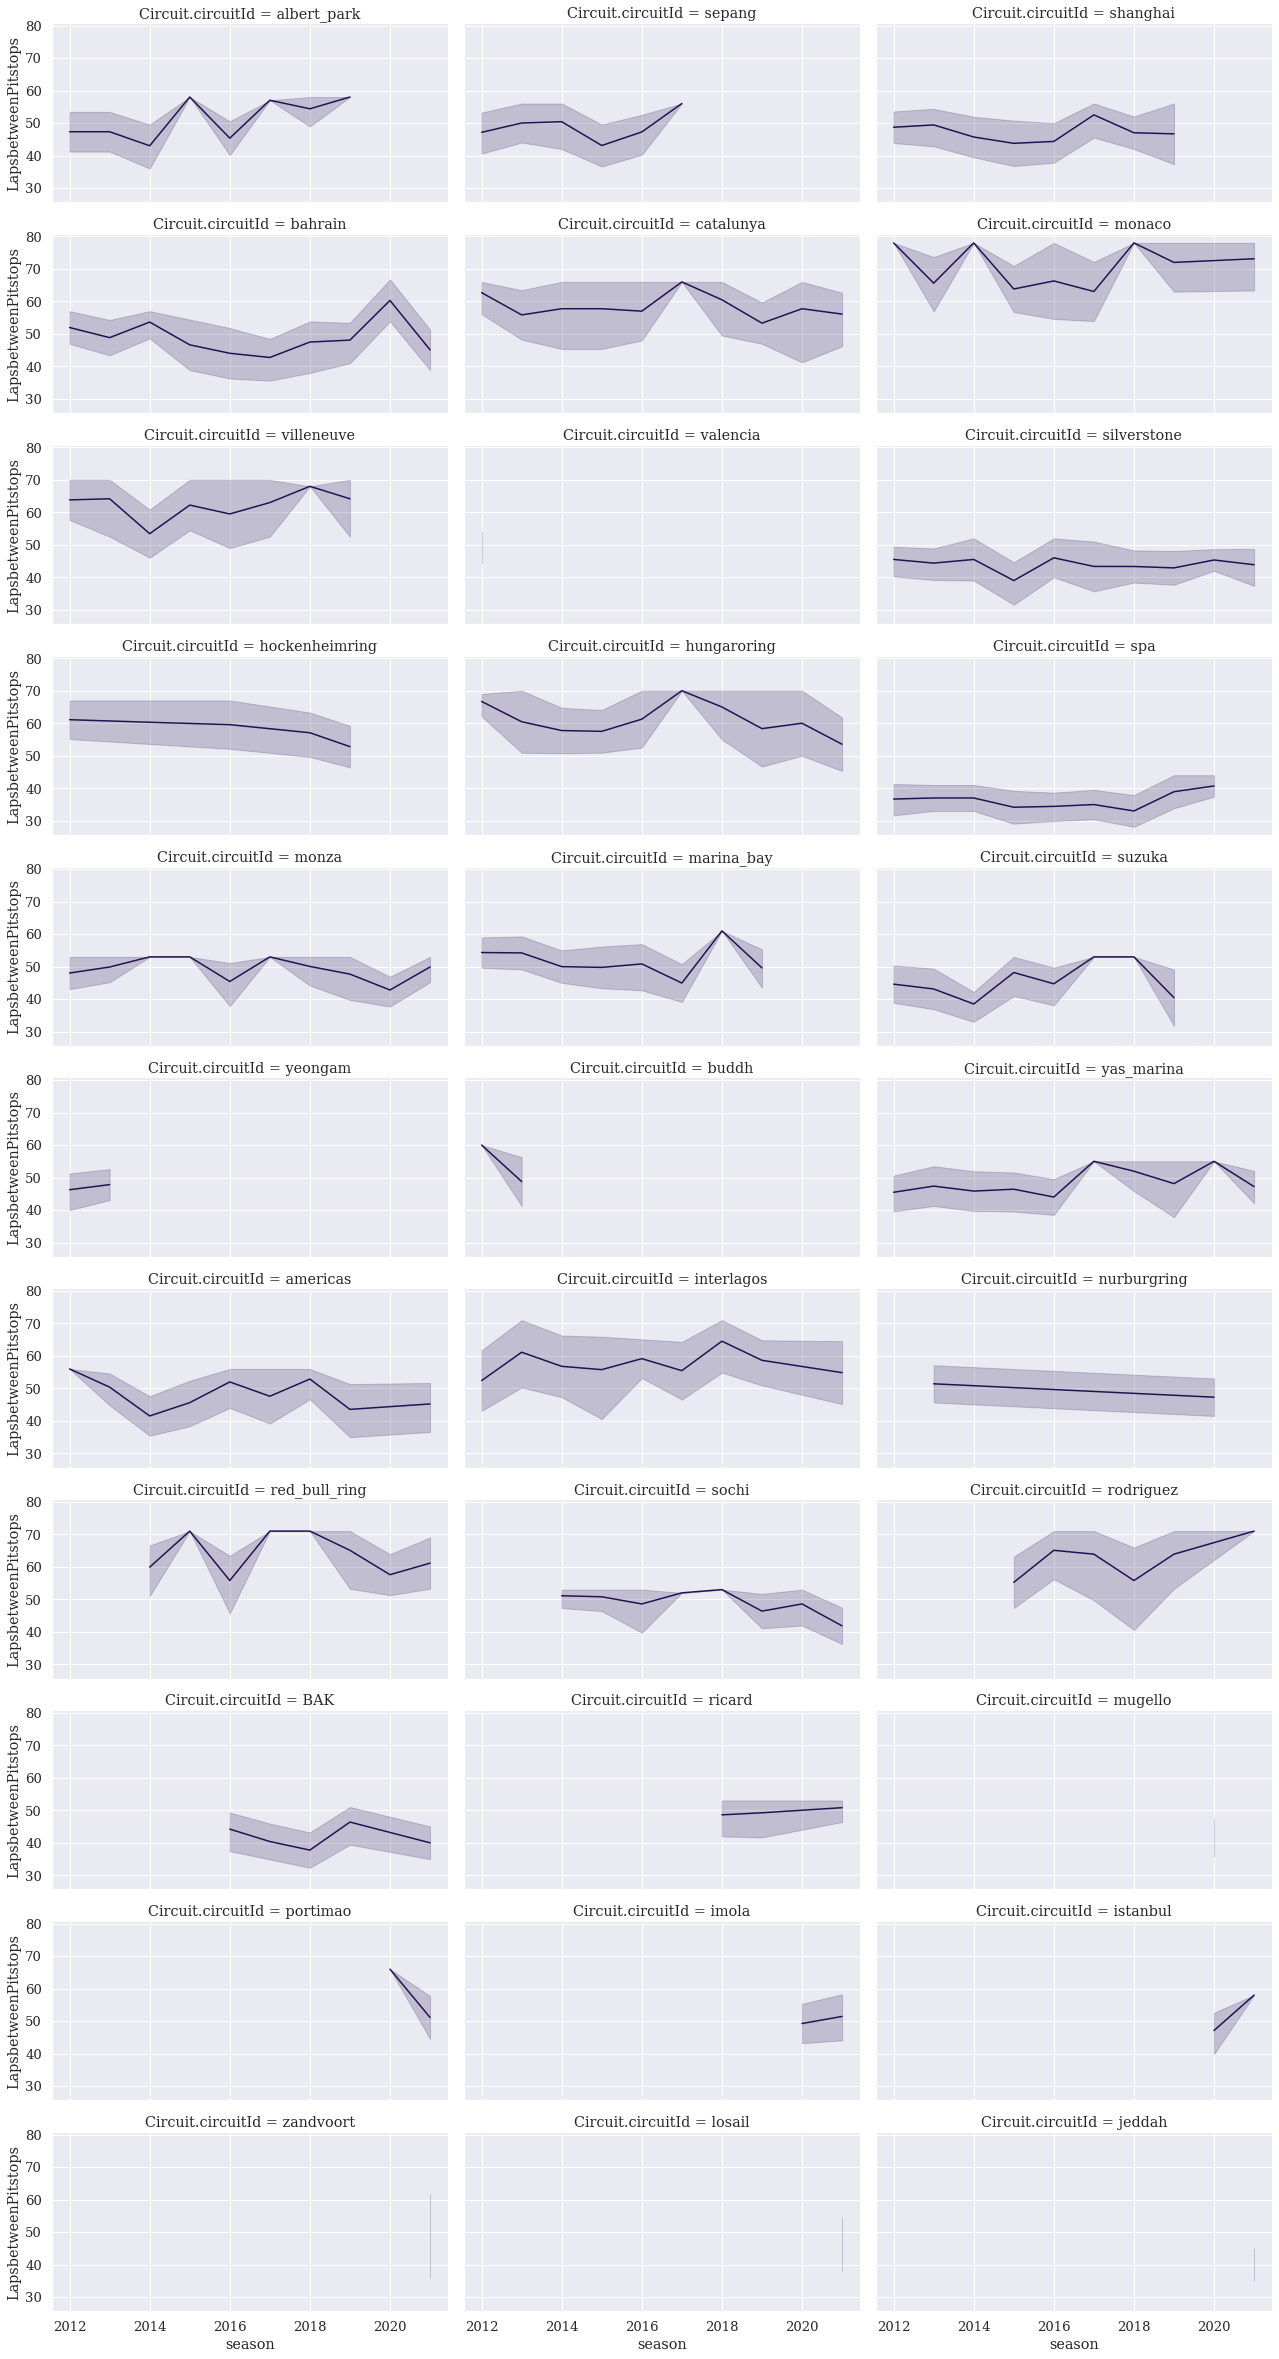

In [147]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.relplot(data=PitsExtraDF_Finished,x="season", y="LapsbetweenPitstops",col="Circuit.circuitId",col_wrap=3,kind="line",height=3,aspect=2)

### Average number of laps between pit stops

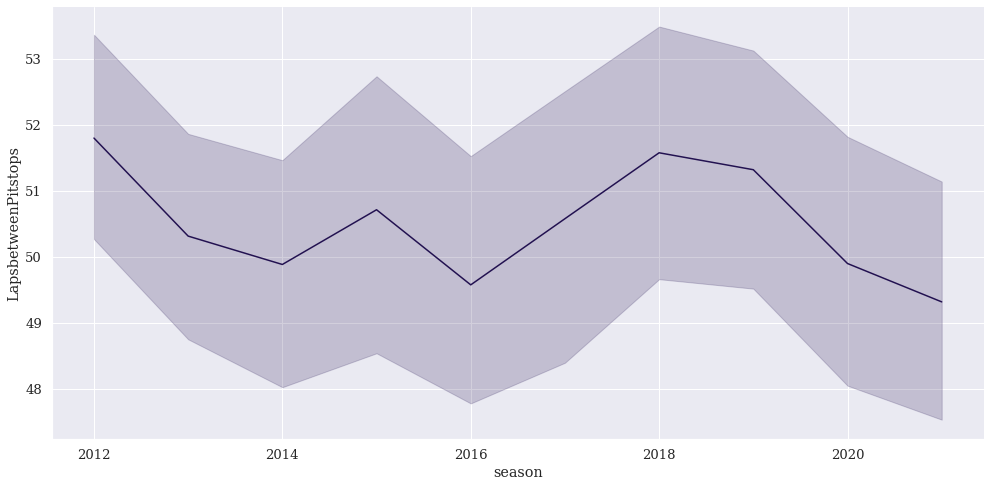

In [151]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.relplot(data=PitsExtraDF_Finished,x="season", y="LapsbetweenPitstops",kind="line",height=7,aspect=2)